# Behavioral foundation for commercial non-profits in finance
============================================

Latest edits: 6/9/15

Notes:

**Karna Basu and Jonathan Conning**

Department of Economics
Hunter College


*Abstract:* We explore new behavioral microfoundations for a theory of 'commercial non-profits.' In the spirit of Henry Hansmann's suggestion that in low regulation environments non-profits serve as "a crude form of consumer protection" our theory helps understand therole and ubiquity of non-profit and 'hybrid' (e.g. for-profits owned and/or controlled to varying degrees by socially-minded investors) financial intermediaries in low income markets.  However, where Hansmann (1996) and others have focused on asymmetric information problems -- the idea that nonprofits might prevail where patrons are "incapable of observing with any accuracy either the quantity or quality of the goods or services that the firm has contracted to provide to them" -- we draw attention to a different problem: the firm's willingness and incentive to pander to or 'exploit' their customers' self-control problems.  This is an issue that arises even when all parties are symmetrically informed and sophisticated.

Sophisticated present-biased consumers are aware of their later period selves' impulse to renegotiate (or refinance) consumption smoothing plans to achieve long-term savings or loan repayment goals.  This creates a demand for commitment contracts that restrict their later period selves' to not renegotiating carefully laid out plans.  A pure for-profit financial intermediary may find it hard to credibly commit to not offering such refinancing options at later dates because clients understand full well that the intermediary can profit by doing so.  This limits the pure for-profit firm to offering credible but costly renegotiation-proof contracts that reduce the gains to trade.  In such circumstances a commercial non-profit which has adopted a legal ownership/governance structure which places limits on the distribution of profits may be in a position to offer more attractive contracts that pure for-profits.  We show how different equilibrium market and ownership structures may emerge depending on parameters of the economic environment, and apply the insights to a discussion of the development of modern microfinance and consumer finance in history. 



This (draft of an) Ipython notebook is not the main paper.  It emphasizes only some of the elements of the paper, highlighting a few elements and extensions to the theoretical model and the python code that generates figures and simulations.  

## The model

The paper describes a slightly more general multi-period model but here we specialize it to a three period setting where savers-cum-borrowers have constant relative risk aversion (CRRA) utility. In any period the consumer's instantaneous utility is given by $u(c)=c^{1-ρ}/(1-ρ)$.  Over three period the agent maximizes utility

$$ U(c₀,c₁,c₂)=u(c₀)+β[δu(c₁)+δ²u(c₂)]$$ 

The consumer has an autarky income stream ${y}=\{y_{0},y_{1},y_{2}\}$ which defines autarky or reservation utility $ \overline{u} = U(y₀,y₁,y₂)$ but in general will prefer a smoother consumption profile from contracting on financial markets. 

### The Monopoly Lender's contract

A monopoly lender (who can credibly commit to not-renegotiate contracts) offers our present-biased consumers a contract that maximizes the present value of profits
$$\Pi \left( c_{0},c_{1},c_{2}\right) =\sum\limits_{t=0}^{2}\frac{\left( y_{t}-c_{t}\right) }{\left( 1+r\right) ^{t}}$$
subject to the agent's intertemporal participation constraint
$$u(c_{0})+\beta \left[ \delta u(c_{1})+\delta ^{2}u(c_{2})\right] \geq \overline{u}$$

The client may be a lender and/or a saver, depending on their initial income stream and preferred/feasible smoothed consumption stream available from contracting.  

The first order conditions imply $u^{\prime }(c_{o})=\beta \delta (1+r)u^{\prime }(c_{1})=\beta \delta ^{2}(1+r)^{2}u^{\prime }(c_{2})$. To simplify, let us assume only for presentation purposes that
$$\delta =\frac{1}{1+r}$$
With this simplification the FOC imply $u^{\prime }(c_{1})=u^{\prime }(c_{2})$ and hence that any optimal solution will keep the agent at constant consumption in the last two periods $c_{1}=c_{2}=\overline{c}$.  For CRRA utility $u^{\prime }(c)=c^{-\rho }$ we can use the FOC to find $\overline{c}=\beta ^{\frac{1}{\rho }}c_{0}$. Substituting this into the agent's binding participation constraint then allows us to solve for 
$$c_{0}=\left[ \frac{\overline{u}(1-\rho )}{1+\beta ^{\frac{1}{\rho }}\left( \delta +\delta ^{2}\right) }\right] ^{\frac{1}{1-\rho }}$$

### Python implementation to solve for optimal contracts 

#### Object oriented design the parent 'Contract' class

This ipython notebook solves for optimal contracts between a lender and a client. The python code makes use of Object oriented programming (OOP) ideas for modular design and more compact code. 

First we create a generic 'Contract' class that defines a few attributes (e.g. default parameters of the utility function, initial endowments, etc.) and useful methods to calculate profits, utility, etc. Later we will define MonopolyContract and CompetitiveContract as subclasses that will inherit and extend attributes and methods to solve related models. 

Before anything else, a few commands to import useful python libraries, and notebook settings to ake plots appear inline.

In [1]:
%matplotlib notebook
import sys
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)    # array printing format 

Now the definition of the Contract class.  

In [2]:
class Contract(object): 
    
    def __init__(self,beta,y=None):         # constructor method to set default params. 
        self.beta  = beta                   # present bias in β-δ framework
        self.rho   = 0.95                   # 1/rho = elasticity of substitution
        if y is None:                       # default y array if none specified
            self.y = np.array([100,100,100])
        else:
            self.y = y     
        self.r     = 0.0                     # bank's opportunity cost of funds
        self.delta = 1/(1+self.r)            # agent's psychic discount factor     
    
    def print_params(self):    
        """ print out parameters """
        params = vars(self)
        for p in sorted(params):    # print attributes alphabetically  
            print("{0:<7} : {1}".format(p,params[p]))
        
    def u(self,ct):
        """ utility function """
        return  ( (1/(1-self.rho)) * ct**(1-self.rho)  )
    
    def PV(self,c):         
        """discounted present value of any stream c"""
        return  c[0] + sum((c[t]* (1/(1+self.r))**t for t in range(1,len(c))) )  
    
    def PVU(self,c,beta):         
        """discounted present utility value of any stream c"""        
        return  self.u(c[0]) + beta * sum((self.u(c[t])*self.delta**t  for t in range(1,len(c))) )
           
    def profit(self,c,y):   
        """ present value of lender profits when exchanges c for y""" 
        return  self.PV(y)-self.PV(c)
    
    def negprofit(self,c):      
        """ Negative profits (for minimization)"""
        return  -(self.PV(self.y) - self.PV(c))
       
    def indif(self, ubar, beta):
        """ returns function u(c1, c2) for graphing indifference curves in c1-c2 space.  
        if beta = 1, will describe self 0's preferences """
        def idc(c1):
            return np.array((((1-self.rho)/(beta*self.delta))
                  *(ubar-self.u(c1)))**(1/(1-self.rho)))
            
        return idc

Let's demonstrate simple use. The following call establishes 'c' as a particular object instance of the Contract class. In this example we then initialize $\beta$ explicitly for this instance. Other attributes (as the value of the income stream y are initialized to default values when c is setup since no value was specified). 

We then call on the print_params method to print out a summary of properties (parameters) of this specific contract c.

In [3]:
c = Contract(beta = 0.8)
c.print_params()

beta    : 0.8
delta   : 1.0
r       : 0.0
rho     : 0.95
y       : [100 100 100]


Let's plot an indifference curve in c1-c2 space.  For example if the agent in autarky has income $\{y_{0},y_{1},y_{2}\}$ and no access to saving or borrowing then (from period 0 self's perspective) entering period 1 they have reservation utility $u(y_{1})+\delta u(y_{2})=\overline{u}_{0}$.  But when period 1 rolls around their preferences change. From period 1 self's perspective they have reservation utility $u(y_{1})+\beta \delta u(y_{2})=\overline{u}_{1}$.  

### Monopoly contracts

The contract class defines a generic contract which holds consumption stream objects of the form $\left( c_{0},c_{1},c_{2}\right)$ and allows a few manipulations.  Now comes the job of solving for optimal contracts and we do this with a 'monopoly contract' or mon__contract class which inherits the attributes and methods of the more generic contract class and then adds a few methods such as calculating the optimal contract full commitment and renegotiation-proof contracts in the monopoly lender case.


#### Full-commitment contracts

When the monopolist can commit to not-renegotiating the contract (i.e. to not pandering to the period-1 self's desire to renegotiate period-0's contract) it searches for the contract that solves

$$\max \ (y_{0}-c_{0})+\frac{(y_{1}-c_{1})}{(1+r)}+\frac{(y_{2}-c_{2})}{(1+r)^{2}}$$
subject to the participation constraint
$$u\left( c_{0}\right) +\beta \left[ \delta u\left( c_{1}\right) +\delta ^{2}u\left( c_{2}\right) \right] \geq u\left( y_{0}\right) +\beta \left[ \delta u\left( y_{1}\right) +\delta ^{2}u\left( y_{2}\right) \right] $$
When $\delta =\frac{1}{(1+r)}$ for the CRRA case an optimum will set $c_{1}=c_{2}=\overline{c}$ and $\overline{c}=\beta ^{\frac{1}{\rho }}c_{0}$ from which a closed form solution can be easily found (see fcommit() function below for formulas).

**Note** that we are here assuming that the consumer has no choice but to consume their income stream $y$ under autarky.  This would be true if the agent does not have acess to any 'own savings' technologies.  Later below we see how things change only slightly when we allow them to use own savings to create a slightly more smooth autarky consumption stream (not perfectly smooth because they cannot overcome their self-control problems on their own).

#### Renegotiaton-proof contracts

The agent's period-1-self's preferences differ from those of his period 0 self so they will often want to renegotiate any contract their period 0 self contracted, and the bank can profit from this renegotiation so long as its renegotiaton cost $\kappa $ is low.   In particular if the period-0-self agreed to contract $\left( \bar{c}_{0},\bar{c}_{1},\bar{c}_{2}\right) $ a monopolist would offer to renegotiate the remaining $(\bar{c}_{1},\bar{c}_{2})$ to contract $\left( c_{1}^{r},c_{2}^{r}\right) $ chosen to maximize
$$\max \ \ (y_{1}-c_{1})+\frac{(y_{2}-c_{2})}{(1+r)}$$
$$s.t.\ \ \ \ \ u(c_{1})+\beta \delta u(c_{2})\geq u(\bar{c}_{1})+\beta \delta u(\bar{c}_{2})$$
We can show from the agent's first order conditions for the CRRA case that a renegotiated contract will always satisfy $c_{2}=\beta ^{\frac{1}{\rho }}c_{1}$ and indeed for CRRA we get the closed form:
$$c_{1}^{r}(\bar{c}_{1},\bar{c}_{2})=\left[ \frac{\overline{u}(\bar{c}_{1},\bar{c}_{2})(1-\rho )}{1+\delta \beta ^{\frac{1}{\rho }}}\right] ^{\frac{1}{1-\rho }}$$

and $c_{2}^{r}(\bar{c}_{1},\bar{c}_{2})=\beta ^{\frac{1}{\rho }}c_{1}^{r}(\bar{c}_{1},\bar{c}_{2})$.  See the reneg(c) function.

A sophisticated present-biased consumer anticipates that this type of renegotiation may happen and will only agree to renegotiation-proof contracts that do not renegotiate to favor their period 1 selves.  The profit-maximizing renegotiation-proof contract solves


$$\max_{c_{0},c_{1},c_{2}}\Pi \left( c_{0},c_{1},c_{2}\right) $$
$$U(c_{0},c_{1},c_{2})\geq U_{0}(y_{0},y_{1},y_{2})$$
$$\Pi \left( c_{1}^{r},c_{2}^{r}\right) -\Pi \left( c_{1},c_{2}\right) \leq \overline{\kappa }$$
The first constraint is the period 0 self's participation constraint and the second is the no-renegotiation proof constraint that the bank not find it profitable to offer to renegotiate to the contract that period-1 self will demand.

In [4]:
class MonopolyContract(Contract):                    # build on contract class
                                                    
    def __init__(self,beta):
        super(MonopolyContract,self).__init__(beta)    # make sure inherits parent class properties
        self.kappa  = 0                                # cost of renegotiation        
        self.guess  = self.y                           # initial guess for solver
        
    def fcommit(self):                                
        """monopolist optimal full commitment contractwith period0 self
        from closed form solution for CRRA"""
        A = ((self.PVU(self.y,self.beta) *(1-self.rho) )**(1/(1-self.rho)) )
        B = (1 + self.beta**(1/self.rho) * (self.delta + self.delta**2))**(1/(self.rho-1))
        c0 = A*B
        c1 = c0 *(self.beta * self.delta *(1+self.r)  )**(1/self.rho)
        c2 = c0 *(self.beta * self.delta**2 *(1+self.r)**2  )**(1/self.rho) 
        return np.array([c0,c1,c2])
    
    def reneg(self,c):                 
        """ Renegotiated contract offered to period-1-self   
        c_0 is past but (c_1,c_2) now replaced by (cr_1, cr_2)"""
        PU =  self.u(c[1]) + self.beta*self.delta*self.u(c[2])
        A  =  (PU *(1-self.rho) )**(1/(1-self.rho)) 
        B = (1 + self.beta**(1/self.rho) * self.delta)**(1/(self.rho-1))
        cr0 = c[0]
        cr1 = A*B
        cr2 = cr1 *(self.beta * self.delta *(1+self.r)  )**(1/self.rho)
        return np.array([cr0,cr1,cr2])
    
    def reneg_proof_cons(self,c):                 
        """ the renegotiation-proof constraint gain from renegotiation 
        cannot exceed its cost kappa"""                                           
        return  -(self.profit(self.reneg(c),self.y)                   -  self.profit(c,self.y)  - self.kappa)     
    
    def participation_cons(self,c):
        return self.PVU(c,self.beta)  - self.PVU(self.y,self.beta)
        
    def reneg_proof(self):                           
        """calculate renegotiation-proof contract 
        supplies constraints to solver that bank can't profit too much
        and period 0 borrower participation"""
        
        cons = ({'type': 'ineq',                          
                 'fun' : self.reneg_proof_cons },    
                {'type': 'ineq', 
                 'fun' : self.participation_cons })      
        res=minimize(self.negprofit, self.guess, method='COBYLA',                     constraints = cons)
        
        return res

Let's create an object instance which we will call cM, printout the parameters associated with this instance and then run a few checks to make sure the cM.reneg function works right:

In [5]:
cM = MonopolyContract(0.8)
cM.print_params()

beta    : 0.8
delta   : 1.0
guess   : [100 100 100]
kappa   : 0
r       : 0.0
rho     : 0.95
y       : [100 100 100]


In [6]:
cMF = cM.fcommit()         # the full commitment contract 
cMR = cM.reneg(cMF)        # what renegotiate to if full commitment unantipatedly undone     
print(cMF, cMR)

[ 115.51   91.33   91.33] [ 115.51  101.35   80.13]


Note that cMR is __not__ the renegotiation-proof contract. It is what the bank would renegotiate if an accepted commitment contract were suddenly and unanticipatedly undone.  We'll solve for the renegotiation-proof contract shortly.  

First let's just check that participation constraints are being met (consumer should to be pushed below their period-0 self's autarky utility under cMR):

In [7]:
print("PVU from cMF: {:4.2f}, from y: {:4.2f}, and from cMR: {:4.2f}"
      .format(cM.PVU(cMF,cM.beta),cM.PVU(cM.y,cM.beta),cM.PVU(cMR,cM.beta)))

PVU from cMF: 65.46, from y: 65.46, and from cMR: 65.44


The bank should profit from this type of opportunistic renegotiation:

In [8]:
print("PV profits from cMF: {:4.2f}   From cMR: {:4.2f}".format(cM.profit(cMF,cM.y),cM.profit(cMR,cM.y)))

PV profits from cMF: 1.82   From cMR: 3.01


In [9]:
# Let's find reneg-proof contract for pure profit with zero reneg. cost
cM.kappa =0
cM.guess = cMF
cMRP = cM.reneg_proof().x
cMRP

array([ 116.2 ,  102.3 ,   80.88])

In [10]:
print("PV profits from full commitment cMF: {:4.1f}, from renegotiation-proof cMRP: {:4.1f}"
      .format(cM.profit(cMF,cM.y),cM.profit(cMRP,cM.y)))

PV profits from full commitment cMF:  1.8, from renegotiation-proof cMRP:  0.6


As expected the bank's profits are lowered due to its inability to commit to not renegotiate.

Here's a plot.

<IPython.core.display.Javascript object>


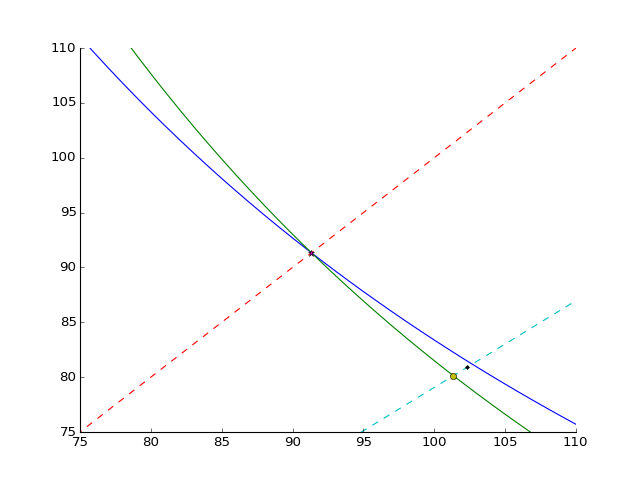

In [11]:
c1 = np.arange(200)

ubar0 = c.PVU(cMF[1:3], 1.0)
idc0 = c.indif(ubar0, 1.0)

ubar1 = c.PVU(cMF[1:3],c.beta)
idc1 = c.indif(ubar1,c.beta)

fig, ax = plt.subplots()
plt.plot(c1,idc0(c1),          
         c1,idc1(c1), 
         c1, c1,'--',
         c1, c.beta**(1/c.rho)*c1,'--',
         cMF[1], cMF[2],'*',
         cMR[1], cMR[2],'o',
         cMRP[1], cMRP[2],'.')

ax.spines['right'].set_color('none'), ax.spines['top'].set_color('none')
plt.ylim((75,110)), plt.xlim((75,110))
ax.xaxis.tick_bottom(),ax.yaxis.tick_left()
plt.show()

In [12]:
for ctr in ['cMF ', 'cMR ', 'cMRP']:
    print(ctr +":", eval(ctr))

cMF : [ 115.51   91.33   91.33]
cMR : [ 115.51  101.35   80.13]
cMRP: [ 116.2   102.3    80.88]


##Optimal contract when renegotiation cost $\kappa $ >0

Let's draw a plot to explore how the renegotiation cost $\kappa $ affects the terms of the contract and firm profits

<IPython.core.display.Javascript object>


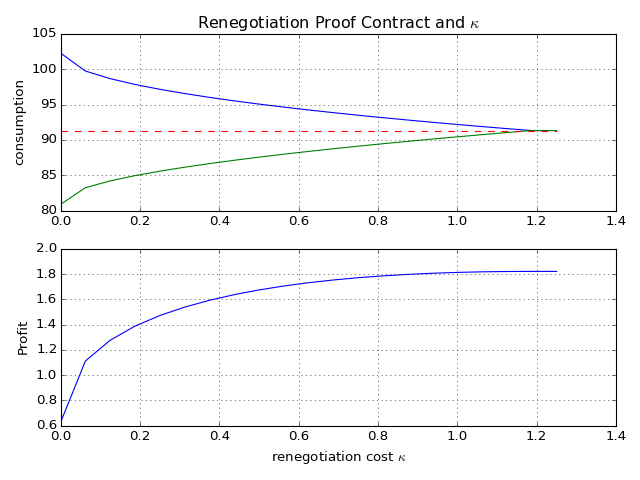

In [13]:
# Note:  re-run all cells above if the plot seems wrong
cM.y = np.array([100,100,100]) 
cMF = cM.fcommit()
num_pts = 21
kaps = np.linspace(0, 1.25, num_pts)      # different renegotiation cost values 
cMRP, profitRP = np.zeros((3,num_pts)), np.zeros(num_pts)  # init (c0,c1,c2) and profits at each kappa

for i in range(0,num_pts):               # look through kappa recalculating optimal contract each time
    cM.kappa = kaps[i] 
    cMRP[:,i] = cM.reneg_proof().x 
    profitRP[i] = cM.profit(cMRP[:,i],cM.y)

c0,c1,c2 = cMRP[0,:], cMRP[1,:],cMRP[2,:]                # save results for plotting

fig, (ax0, ax1) = plt.subplots(nrows = 2)
#ax0.plot(kaps, c0, label='$c_{0}$')
ax0.plot(kaps, c1, label='$c_{1}$')
ax0.plot(kaps, c2, label='$c_{2}$')
ax0.plot(kaps, np.ones(num_pts)*cMF[1], '--', label='$c_{F}$')
ax0.grid()
ax0.set_title('Renegotiation Proof Contract and $\kappa$'), ax0.set_ylabel('consumption')
ax0.legend(loc=9,bbox_to_anchor=(0.5, -1.7), ncol = 3)

ax1.plot(kaps, profitRP)
ax1.set_ylabel('Profit')
ax1.grid()
ax1.set_xlabel('renegotiation cost $\kappa$')
plt.tight_layout()
plt.show()

At lower renegotiation costs the bank is forced to offer less consumption smoothing in periods 1 and 2 as a way to credibly commit to limit their gains to renegotiation with a period 1 self.  Hence bank profits rise with their ability to commit to incur a renegotiation cost $\kappa$

We haven't plotted $c_{0}$ for each $\kappa$ but that's because it varies less relative to $c_{1}, c_{2}$ and way above the full commitment consumption smoothing.

In [14]:
print("cMF[0]: ",cMF[0])
print("  max, mean and min of c0 in cMRP:")
for item in (c0.max(),c0.mean(),c0.min()):
    print("{:5.2f}".format(item), end=' ')

cMF[0]:  115.513783331
  max, mean and min of c0 in cMRP:
116.20 115.68 115.51 

<IPython.core.display.Javascript object>


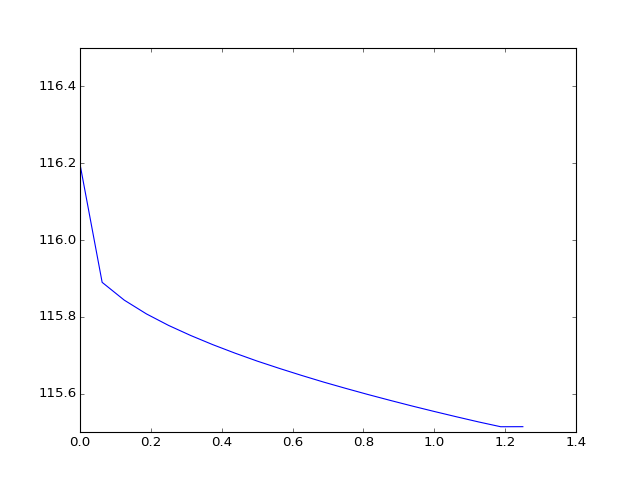

In [15]:
fig2 = plt.figure()  
plt.plot(kaps, c0), plt.ylim((115.5,116.5))
plt.show()

### The choice to become a commercial non-profit

### Modeling the non-profit

The no-renegotiation constraint has two parts.  A pure for-profit captures fraction $\alpha = 1$ of profits and faces renegotiation cost 
not-for-profit of type $\alpha$ and faces renegotiation cost $h(\alpha) = h(1)$.  More generally a non-profit of type $\alpha$ has a no-renegotiation constraint of the form 
$$\alpha \left[ \Pi ^{R}-\Pi \right] \geq h(\alpha )$$

To be specific here let's model this as 
$$h(\alpha )=\kappa \left( 1-\alpha \right) $$

So that at $\alpha =1$ there is no cost to renegotiation and at $0< \alpha <1$ there is a non-negative non-pecuniary cost of up to $\kappa$.  The constraint can then be written as 
$$\left[ \Pi ^{R}-\Pi \right] \geq C(\alpha )=\frac{h(\alpha )}{\alpha }$$

<IPython.core.display.Javascript object>


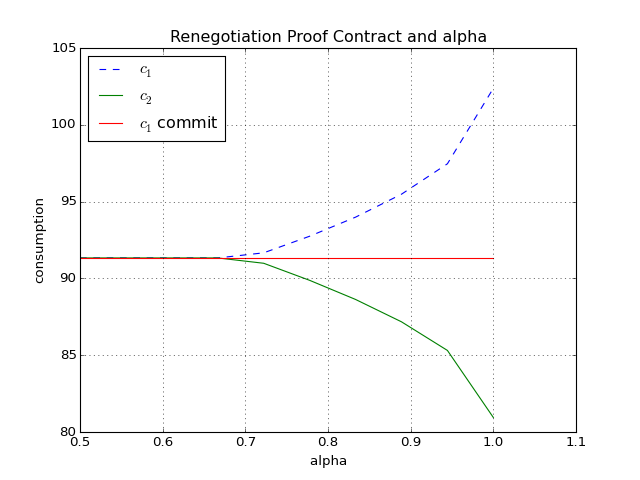

In [16]:
# Similar to above but solve for contract as a function of firm type ALPHA
y = np.array([100,100,100])          # To see how endowment affects contract
cM.y     = y                            
cMF      = cM.fcommit()
num_pts  = 10
alphs    = np.linspace(0.5,1.0,num_pts)       # iterate over different values of beta
C        = 4*(np.ones(num_pts) - alphs)     #  h(alpha)/alpha  or cost of renegotiaton
cMRP     = np.zeros((3,num_pts))          # matrix for (c0,c1,c2) at each kappa
profitRP = np.zeros(num_pts)
NprofitRP =np.zeros(num_pts)

for i in range(0,num_pts):
    cM.kappa = C[i]                 # change optimal contract
    cMRP[:,i] = cM.reneg_proof().x 
    cM.guess =  cMRP[:,i]                 # use this sol as guess for next optimum
    profitRP[i] = cM.profit(cMRP[:,i],y)
    NprofitRP[i] = alphs[i]*cM.profit(cMRP[:,i],y)

c0,c1,c2 = cMRP[0,:], cMRP[1,:],cMRP[2,:]                # save results for plotting

fig3 = plt.figure()  
plt.plot(alphs,c1,'--',label='$c_{1}$')
plt.plot(alphs,c2,label='$c_{2}$')
plt.plot(alphs,np.ones(num_pts)*cMF[1],label='$c_{1}$ commit')
plt.grid()
plt.title('Renegotiation Proof Contract and alpha' )
plt.xlabel('alpha ')
plt.ylabel('consumption')
plt.legend(loc='upper left')
plt.show()

### 'Commercial' non-profits 
A 'pure' for profit (with $\alpha$=1.0) earns a reduced (possibly negative) profit due to it's inability to commit. Seen in the plot as profits the height of the horizontal line.

Any non-profit with $\alpha$ above about 0.4 and below 1.0 can better commit to not renegotiate a larger set of contracts and therefore can offer a more profitable renegotiation-proof contract. Even though they capture only fraction $\alpha$ of those profits, the take home profits exceed the profits of the pure for-profit. 

<IPython.core.display.Javascript object>


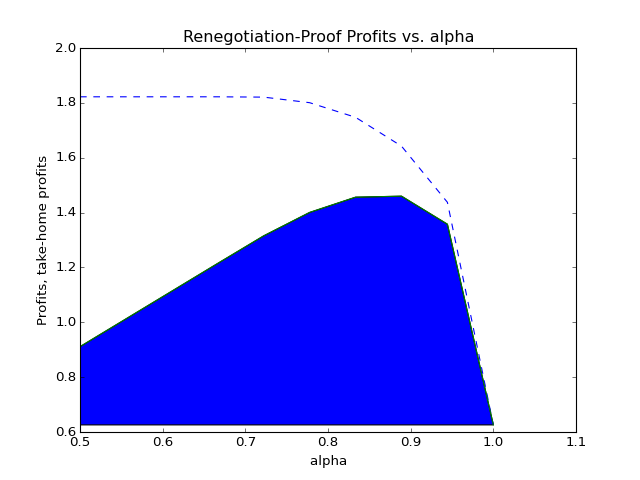

In [17]:
profitRP_full = profitRP[num_pts-1]*np.ones(num_pts) 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Renegotiation-Proof Profits vs. alpha')
plt.xlabel('alpha ')
plt.ylabel('Profits, take-home profits')
plt.plot(alphs,profitRP,'--',label='pure-profit profits')
plt.plot(alphs,NprofitRP,label='Non-profit take home profits')
ax.fill_between(alphs, np.fmax(profitRP_full,NprofitRP), profitRP_full)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=None, ncol=5)

The more profit-focused (higher $\alpha$) banks tend to offer seemingly 'riskier' contracts which concentrate repayment in the last period.  In this case at very high $\alpha$ the consumer actually is a net borrower in period 0 and 1 and faces heavy repayment in period 2.

One interpretation:  Sophisticated consumer knows that a bank that offers a smoothed consumption (balanced repayment) profile will approach their later self to opportunistically offer a new loan which will impose a heavy repayment in the last period. The consumer balks and then only agrees to a contract that the bank can credibly commit to not renegotiate, one that limits the amount of  period 1 self's 

<IPython.core.display.Javascript object>


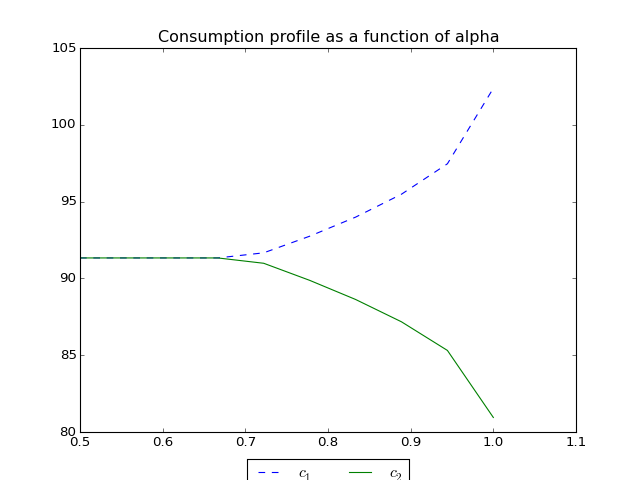

In [18]:
#plot(alphs,cMRP[0,:],label='$c_{0}$')
fig = plt.figure()
plt.plot(alphs,cMRP[1,:],'--',label='$c_{1}$')
plt.plot(alphs,cMRP[2,:],label='$c_{2}$')
plt.title('Consumption profile as a function of alpha')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=None, ncol=5)

<IPython.core.display.Javascript object>


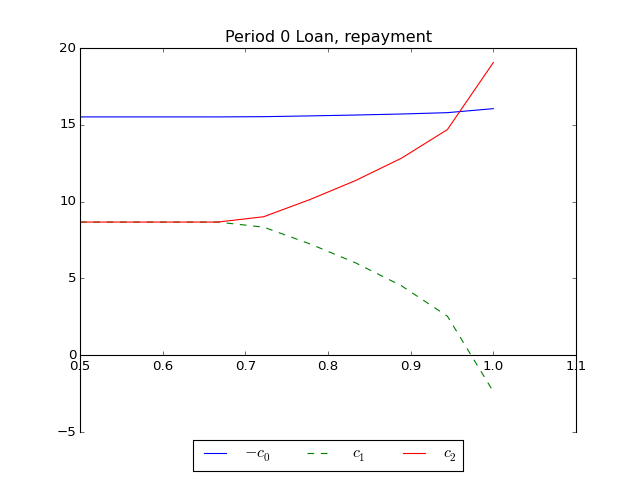

In [19]:
fig = plt.figure()
plt.plot(alphs,cMRP[0,:]-y[0],label='$-c_{0}$')
plt.plot(alphs,y[1]-cMRP[1,:],'--',label=' $c_{1}$')
plt.plot(alphs,y[2]-cMRP[2,:],label='$c_{2}$')
plt.title('Period 0 Loan, repayment')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0),
          fancybox=None, ncol=5)
plt.gca().spines['bottom'].set_position(('data',0))

**Loan, repayment and Profit breakdown by periods as function of alpha**

In [20]:
print(" alpha   c0        c1      c2          profit = (y0-cMRP0) + (y1-cMRP1) + (y2-cMRP2)")
print("-"*85)
for i,a in enumerate(alphs):
    print("{:6.2f}:  {:6.2f}   {:6.2f}   {:5.2f},    {:8.2f} = {:8.2f}   + {:8.2f}   + {:8.2f}   "
          .format(a, cMRP[0,i], cMRP[1,i], cMRP[2,i],profitRP[i],y[0]-cMRP[0,i],y[1]-cMRP[1,i],y[2]-cMRP[2,i],))

 alpha   c0        c1      c2          profit = (y0-cMRP0) + (y1-cMRP1) + (y2-cMRP2)
-------------------------------------------------------------------------------------
  0.50:  115.51    91.33   91.33,        1.82 =   -15.51   +     8.67   +     8.67   
  0.56:  115.51    91.33   91.33,        1.82 =   -15.51   +     8.67   +     8.67   
  0.61:  115.51    91.33   91.33,        1.82 =   -15.51   +     8.67   +     8.67   
  0.67:  115.51    91.33   91.33,        1.82 =   -15.51   +     8.67   +     8.67   
  0.72:  115.53    91.66   90.98,        1.82 =   -15.53   +     8.34   +     9.02   
  0.78:  115.58    92.75   89.87,        1.80 =   -15.58   +     7.25   +    10.13   
  0.83:  115.64    93.99   88.63,        1.75 =   -15.64   +     6.01   +    11.37   
  0.89:  115.70    95.48   87.17,        1.64 =   -15.70   +     4.52   +    12.83   
  0.94:  115.79    97.46   85.31,        1.44 =   -15.79   +     2.54   +    14.69   
  1.00:  116.05   102.38   80.95,        0.63 =   -16.0

The inability to commit means the renegotiation proof contract doesn't smooth consumption very well for the consumer.  This ends up hurting the bank, since they must now 'compensate' the consumer for the higher variance of consumption if the participation constraint is still to be met.  

The code that follows produces a grid of subplots to illustrate how the results (the relation between $\alpha$ and retained profits) depends on the initial y vector, which in turn also determines whether this will be borrowing or saving.  

##The role of y
###Plot captured profits and net saving in each period as function of $\alpha$

Left: captured profits (shaded = NP dominates). Right: net saving in each period as function of α :


<IPython.core.display.Javascript object>


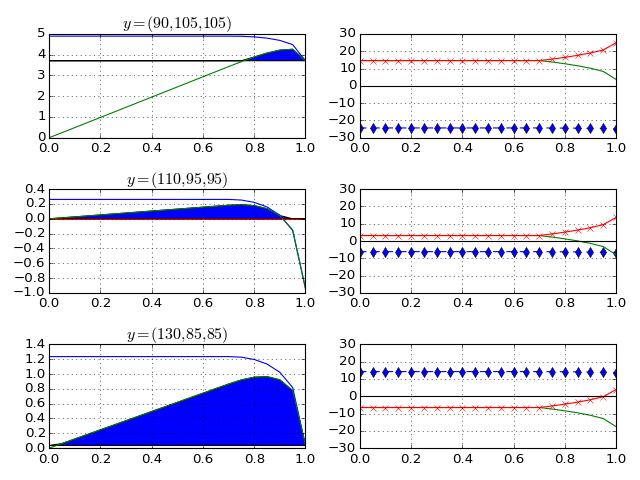

In [21]:
print("Left: captured profits (shaded = NP dominates). Right: net saving in each period as function of α :")
num_pts  = 21
alphs    = np.linspace(0,1,num_pts)       # iterate over different alphas
C        = 4*(np.ones(num_pts)-alphs)     # h(alpha)/alpha  or cost of renegotiaton
cMRP     = np.zeros((3,num_pts))             # to store (c0,c1,c2) for each alpha
profitRP = np.zeros(num_pts)
NprofitRP= np.zeros(num_pts)

fig, ax = plt.subplots(10,sharex=True)
numy0 = 3     # rows of subplots
ax = plt.subplot(numy0,2,1)

# Vary y contracts (maintaining PV at 300 in zero interest rate setting)
for j in range(1, numy0 + 1):
    y0 = 70 + j*20
    y = np.array([y0,100,100])            
    y = np.array([y0,(300-y0)/2,(300-y0)/2])   
          
    ax1 = plt.subplot(numy0, 2, j*2-1, sharex=ax)  
    for i in range(0, num_pts):
        cM.kappa = C[i]             # change reneg cost  
        cM.y = y
        cMRP[:,i]    = cM.reneg_proof().x 
        cM.guess     = cMRP[:,i]         # store sol as guess for next search
        profitRP[i]  = cM.profit(cMRP[:,i], y)
        NprofitRP[i] = alphs[i]*cM.profit(cMRP[:,i], y)
       #print("alph:{0:4.2f} profitRP:{1:5.2f} ".format(alphs[i],cM.profit(cMRP[:,i],y)))
        
    #ax.set_ylim([0, cM.profit(cMF,y)*1.2])
    
    profitRP_full = profitRP[num_pts-1]*np.ones(num_pts) 
    
    ax1.plot(alphs, profitRP)
    ax1.plot(alphs, NprofitRP)
    ax1.fill_between(alphs, np.fmax(NprofitRP, np.fmax(np.zeros(num_pts),profitRP_full)), np.fmax(profitRP_full,np.zeros(num_pts)))
    ax1.plot(alphs, np.zeros(num_pts))
    ax1.set_title(r'$y=( %2.0f, %2.0f, %2.0f)$' %(y0,y[1],y[2]))
    plt.grid()
    ax2 = plt.subplot(numy0,2,j*2,sharex=ax, sharey=ax)    # Plot contract terms in right column plot
    #ax1.set_ylim([0, 25])
    ax2.plot(alphs, y0 - cMRP[0,:],"d--")
    ax2.plot(alphs, y[1] - cMRP[1,:])
    ax2.plot(alphs, y[2] - cMRP[2,:],"x-")
    ax2.axhline(y=0, color ='k')
    #ax2.plot(alphs, y[0]*np.ones(num_pts))
    #ax2.plot(alphs, y[1]*np.ones(num_pts))
    plt.grid()    
plt.tight_layout()
plt.show()    

In [36]:
plt.close('all')
profitRP_full

array([ 0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,
        0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,  0.04,
        0.04,  0.04,  0.04])

**INTERPRETATION**: The left column of plots above shows renegotiation-proof profits as a function of $\alpha$ where $\alpha$ affects both the share of profits that are captured as well as the cost of renegotiation as described above.  The blue shaded area indicates where commercial non-profits (that choose an $\alpha <1$) capture more profit than a pure for-profit. 

The right column of plots shows the terms of the associated contract displayed as 'net savings' (y0-c0), (y1-c1), and (y2-c2).  When these are positive the client is saving or repaying, when negative they are borrowing.

When we keep the PV of y constant but change the ratio of period zero income y0 to later period income, y vectors that lead to borrowing (lower y0, higher y1,y2) deliver higher full-commitment (and renegotiation-proof) profits at any level of alpha. 

Since most of the profits are in the 0 to 1 period, they weigh more heavily in total profits.  Turning non-profit is only attractive at relatively high values of alpha (since at lower alpha they're forfeiting the period 0-1 profits). At higher y0 (tilted more toward savings) full commitment (and renegotiation-proof) profits are lower The pattern seems to be that as we move toward first period savings...

In [23]:
for p in cM.__dict__:     
    print("{0:<7} : {1}".format(p,params[p]))

kappa   : 0.0
rho     : 0.95
delta   : 1.0
guess   : [ 116.06  102.38   80.94]
r       : 0.0
y       : [100 100 100]
beta    : 0.8


### NOT FINISHED
Profitability as a function of y0

In [24]:
cM.kappa = 0

In [25]:
PDV =300
y0_step = 2
y0_start = 50
y0_end = PDV -50
Y0 = range(y0_start,y0_end,y0_step)
n = len(Y0)
profity0 = zeros(n)
profity0B = zeros(n)
i=0

for y0 in Y0:  
    ybar = (PDV-y0)/2
    cM.y =([y0,ybar,ybar])
    cMF = cM.fcommit()
    cMRP = cM.reneg_proof().x
    cM.guess = cMRP
    profity0[i] = cM.profit(cMRP,cM.y)
    profity0B[i] = cM.profit(cMF,cM.y)
    
    i += 1

In [26]:
plt.plot(profity0,Y0,'b-',label="reneg. proof")
plt.plot(profity0B,Y0,'r',label="full commit")
plt.xlim([-2,6])
plt.ylim([80,160])c

plt.title("Profits as a function of y0")
plt.xlabel("profits $\pi$")
plt.ylabel("y0")
plt.legend(loc='center right')
plt.grid()
plt.axvline()

SyntaxError: invalid syntax (<ipython-input-26-3fcc6e5b8381>, line 4)

## Modifications when consumer has a home savings option##
The above ana

In [ ]:
cM.kappa =0
cM.guess = cMF
cMRP = cM.reneg_proof()
cMRP.x

In [ ]:
plot(alphs,C)

In [ ]:
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(alphs, profitRP)
ax1.plot(alphs, NprofitRP)
ax1.plot(alphs,cM.profit(cMF,y)*ones(num_pts))
ax1.grid(True)
ax1.set_title('Sharing both axes')
ax2.plot(alphs, NprofitRP)
ax3.plot(alphs,cM.profit(cMF,y)*ones(num_pts))
show()

## Other Results

### $\beta$ and loan size

Let's plot the the relationship between period 0 loan size in a full-commitment contract and the extent of present-bias captured by $\beta$

In [ ]:
cM = MonopolyContract(0.8)               # create an instance m

num_pts = 21
betas = linspace(0.1,1,num_pts)           # iterate over different values of beta
CMF = zeros((3,num_pts))                  # a three row matrix to store (c0,c1,c2) for each beta

for i in range(0,num_pts):
    cM.beta = betas[i]                    # change beta before recalculating optimal contract
    CMF[:,i] = cM.fcommit()       

loan   = CMF[0,:] - cM.y[0]               # save results for plotting
repay1 = CMF[1,:] - cM.y[1]
repay2 = CMF[2,:] - cM.y[2]

plot(betas,loan,'--')                          # plot    
plot(betas,repay1)
plot(betas,repay2)
grid()
title('Monopoly Commitment Contract as function of beta')
xlabel('beta')
ylabel('net repayment')
legend(['loan','repay1','repay2'])

### Example full commitment contract (and renegotiation with a naive consumer)

Here is an example of the full-commitment contracts a monopolist offers and the contract a monopolist and a naive consumer would renegotiate to from that same full commitment contract (but note that a intermediary who knows they are dealing with a naive consumer would bait them with a different initial contract). 

In [ ]:
cM.beta = 0.8            # Reset to beta = 0.8 case and print out other parameters
cM.params()

In [ ]:
cMF = cM.fcommit()      
cMr = cM.reneg(cMF)       
y = cM.y
print '0-Discounted utility full commit: {0:4.3f}   and   Naive renegotiate: {1:4.3f}'.format(cM.PVU(cMF), cM.PVU(cMr))
print 'Profits from full commit: {0:4.3f}   and   Naive renegotiate:{1:4.3f}'.format(cM.profit(y,cMF), cM.profit(y,cMr))

##### Scratch play area

#### 3D plots

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

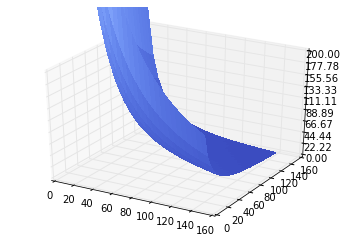

In [55]:
fig = plt.figure()
ax = fig.gca(projection='3d')
C0 = np.arange(10, 150, 5)
C1 = np.arange(10, 150, 5)
C0, C1 = np.meshgrid(C0, C1)
ubar = cM.PVU(cM.y,cM.beta)      
C2 =(((1-cM.rho)/cM.beta)*(ubar- cM.u(C0)-cM.beta*cM.u(C1)))**(1/(1-cM.rho))
surf = ax.plot_surface(C0, C1, C2, rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_zlim(0, 200)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [47]:
ubar = cM.PVU(cM.y,cM.beta)

In [48]:
ubar

64.00988831949365